Grid World Environment 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the GridWorld environment
class GridWorld:
    def __init__(self, grid_size, start_pos, Red_states, Terminal_states):
        self.grid_size = grid_size
        self.start_pos = start_pos
        self.Red_states = Red_states
        self.Terminal_states = Terminal_states

    def reset(self):
        self.current_pos = self.start_pos
        return self.current_pos

    def step(self, action):
        next_pos = (self.current_pos[0] + action[0], self.current_pos[1] + action[1])

        if next_pos[0] < 0 or next_pos[0] >= self.grid_size[0] or next_pos[1] < 0 or next_pos[1] >= self.grid_size[1]:
            return self.current_pos, -1, False

        if next_pos in self.Red_states:
            self.current_pos = self.start_pos
            return self.current_pos, -20, False
        
        if next_pos in self.Terminal_states:
            return next_pos, 0, True

        self.current_pos = next_pos
        return next_pos, -1, False

# Initialize environment
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
grid_size = (5, 5)
start_pos = (4, 0)
Red_states = [(2, 0), (2, 1), (2, 3), (2, 4)]
Terminal_states = [(0, 0), (0, 4)]
env = GridWorld(grid_size, start_pos, Red_states, Terminal_states)

#Epsilon-greedy action selection function
def choose_action(state, Q, epsilon):
    if random.random() < epsilon:
        return random.choice(actions)
    else:
        return actions[np.argmax(Q[state[0], state[1]])]



Sarsa Algorithm

In [2]:
# Define the Sarsa algorithm
def sarsa(env, Q, num_episodes, alpha, gamma, epsilon):
    rewards_per_episode = []
    for _ in range(num_episodes):
        total_reward = 0
        state = env.reset()
        action = choose_action(state, Q, epsilon)
        done = False
        while not done:
            next_state, reward, done = env.step(action)
            total_reward += reward
            next_action = choose_action(next_state, Q, epsilon)
            Q[state[0], state[1], actions.index(action)] += alpha * (reward + gamma * Q[next_state[0], next_state[1], actions.index(next_action)] - 
                                                                     Q[state[0], state[1], actions.index(action)])
            state, action = next_state, next_action
        rewards_per_episode.append(total_reward)
    return Q, rewards_per_episode


Q-learning Algorithm

In [3]:
# Define the Q-learning algorithm
def q_learning(env, Q, num_episodes, alpha, gamma, epsilon):
    rewards_per_episode = []
    for _ in range(num_episodes):
        total_reward = 0
        state = env.reset()
        done = False
        while not done:
            action = choose_action(state, Q, epsilon)
            next_state, reward, done = env.step(action)
            total_reward += reward
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], actions.index(action)] += alpha * (reward + gamma * Q[next_state[0], next_state[1], best_next_action] -
                                                                      Q[state[0], state[1], actions.index(action)])
            state = next_state
        rewards_per_episode.append(total_reward)
    return Q, rewards_per_episode


Initialization

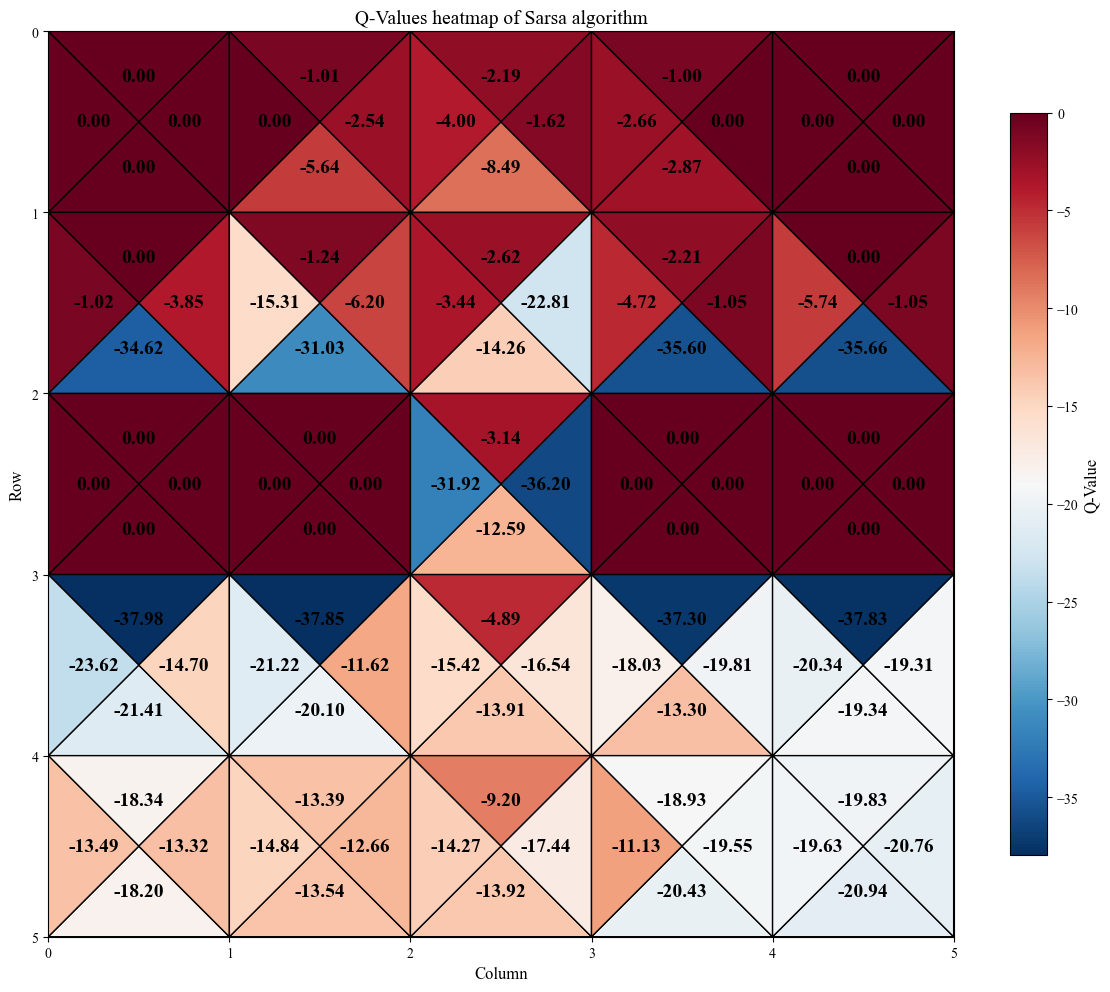

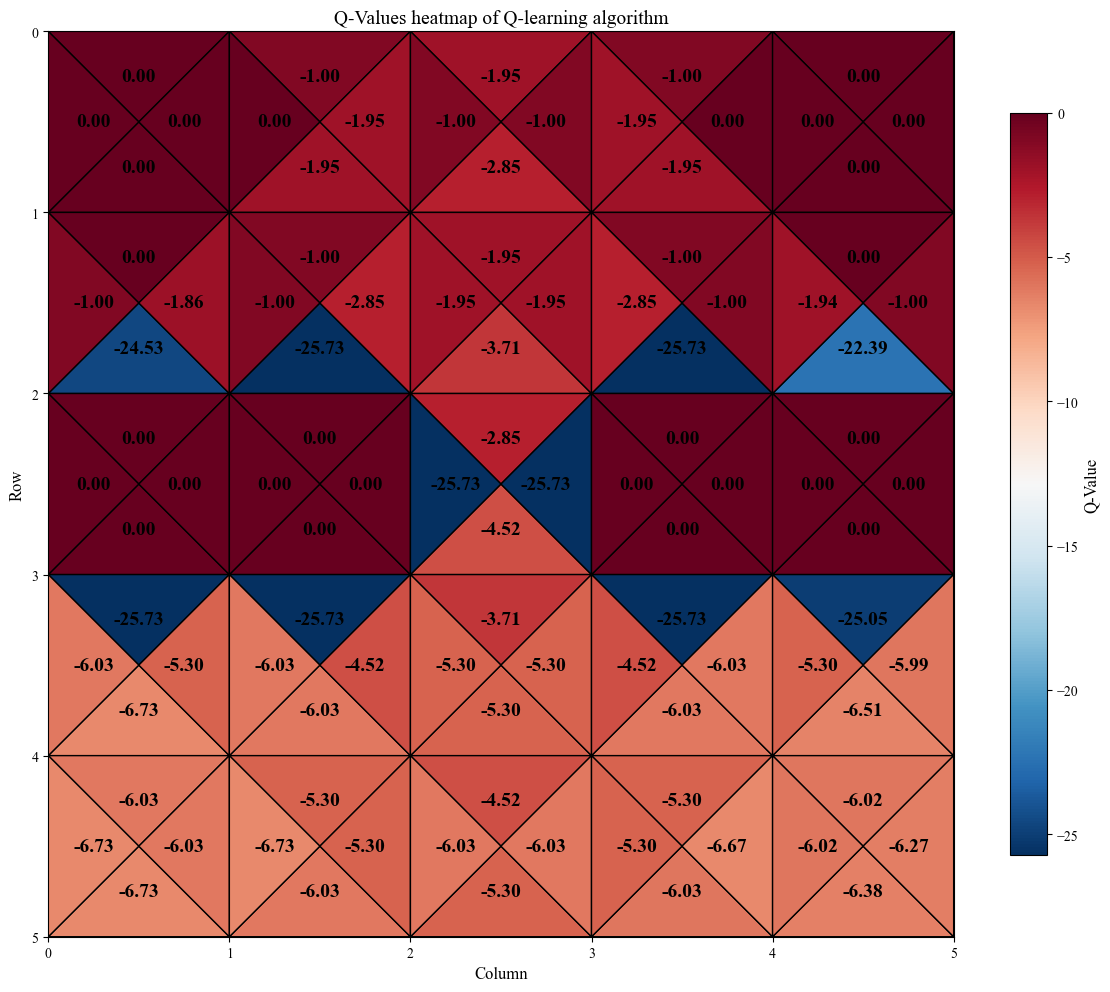

In [4]:
num_episodes = 20000
alpha = 0.4 # learning rate
gamma = 0.95 # discount factor
epsilon = 0.2 # greedy action selection

# Initialize Q-table for Sarsa
Q_sarsa = np.zeros((grid_size[0], grid_size[1], len(actions)))
# Run Sarsa learning
Q_sarsa, rewards_per_episode_sarsa = sarsa(env, Q_sarsa, num_episodes, alpha, gamma, epsilon)

# Initialize Q-table for Q-learning
Q_q_learning = np.zeros((grid_size[0], grid_size[1], len(actions)))
# Run Q-learning
Q_q_learning, rewards_per_episode_q_learning = q_learning(env, Q_q_learning, num_episodes, alpha, gamma, epsilon)

# Function to plot Q-values as heatmap with triangular divisions
def plot_q_values(Q, grid_size, title):
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Get min/max Q-values for color normalization
    vmin, vmax = np.min(Q), np.max(Q)
    
    # Create colormap
    cmap = plt.cm.RdBu_r
    
    # Plot each cell divided into 4 triangles
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Get Q-values for this state [up, down, left, right]
            q_vals = Q[i, j, :]
            
            # Define triangles: each triangle is defined by 3 points
            # Top triangle (up action)
            top_triangle = np.array([[j, i], [j+0.5, i+0.5], [j+1, i]])
            # Bottom triangle (down action)  
            bottom_triangle = np.array([[j, i+1], [j+0.5, i+0.5], [j+1, i+1]])
            # Left triangle (left action)
            left_triangle = np.array([[j, i], [j+0.5, i+0.5], [j, i+1]])
            # Right triangle (right action)
            right_triangle = np.array([[j+1, i], [j+0.5, i+0.5], [j+1, i+1]])
            
            triangles = [top_triangle, bottom_triangle, left_triangle, right_triangle]
            
            # Plot each triangle with its corresponding Q-value color
            for k, (triangle, q_val) in enumerate(zip(triangles, q_vals)):
                # Normalize Q-value for color mapping
                norm_val = (q_val - vmin) / (vmax - vmin) if vmax != vmin else 0.5
                color = cmap(norm_val)
                
                # Create and add triangle patch
                triangle_patch = plt.Polygon(triangle, facecolor=color, 
                                           edgecolor='black', linewidth=1)
                ax.add_patch(triangle_patch)
            
            # Add Q-value text in each triangle
            # Top triangle (up action)
            ax.text(j+0.5, i+0.25, f'{q_vals[0]:.2f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            # Bottom triangle (down action)
            ax.text(j+0.5, i+0.75, f'{q_vals[1]:.2f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            # Left triangle (left action)
            ax.text(j+0.25, i+0.5, f'{q_vals[2]:.2f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            # Right triangle (right action)
            ax.text(j+0.75, i+0.5, f'{q_vals[3]:.2f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold', color='black')
    
    # Set up the plot
    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_aspect('equal')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(grid_size[0] + 1))
    ax.set_yticks(np.arange(grid_size[1] + 1))
    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Invert y-axis to match matrix indexing
    ax.invert_yaxis()
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('Q-Value', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Plot the Q-values
plot_q_values(Q_sarsa, grid_size, 'Q-Values heatmap of Sarsa algorithm')
plot_q_values(Q_q_learning, grid_size, 'Q-Values heatmap of Q-learning algorithm')


Plots

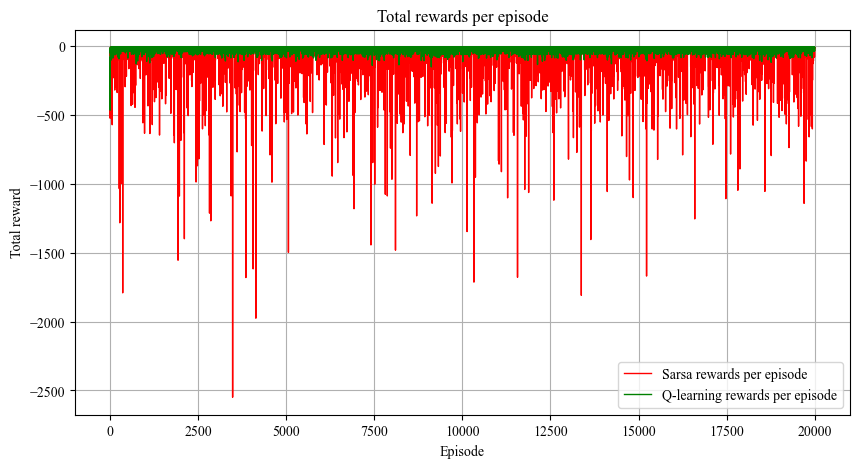

In [5]:
# Plot rewards per episode
def plot_rewards(rewards_per_episode_sarsa, rewards_per_episode_q_learning):
    plt.figure(figsize=(10, 5))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.plot(rewards_per_episode_sarsa, label='Sarsa rewards per episode', color='r', linewidth=1)
    plt.plot(rewards_per_episode_q_learning, label='Q-learning rewards per episode', color='g', linewidth=1)
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.title('Total rewards per episode')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot rewards for both methods
plot_rewards(rewards_per_episode_sarsa, rewards_per_episode_q_learning)


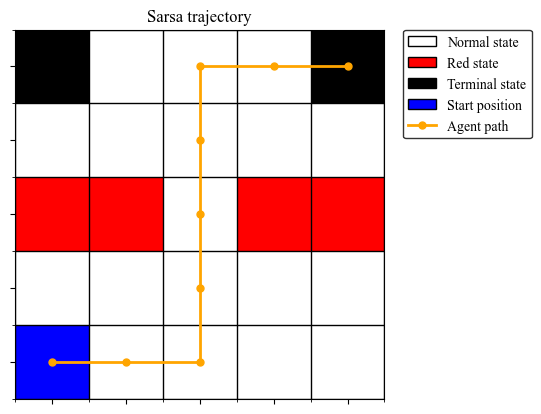

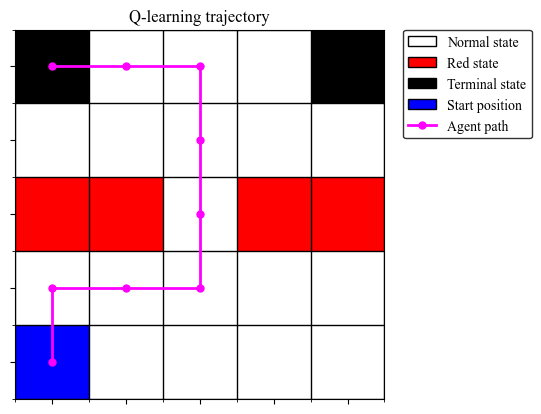

In [6]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Plot trajectory of the agent
def plot_trajectory(grid_size, start_pos, path, Red_states, Terminal_states, title):
    grid = np.zeros(grid_size, dtype=int)
    for r in Red_states:
        grid[r] = 1
    for b in Terminal_states:
        grid[b] = 2
    grid[start_pos] = 3

    cmap = mcolors.ListedColormap(['white', 'red', 'black', 'blue'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    plt.rcParams['font.family'] = 'Times New Roman'
    cax = ax.imshow(grid, cmap=cmap, norm=norm, interpolation='nearest')

    # Choose trajectory color
    if title == 'Sarsa trajectory':
        pathcolor = 'orange'
    else:
        pathcolor = 'magenta'
        
    # Plot trajectory
    y, x = zip(*path)
    ax.plot(x, y, 'o-', color=pathcolor, linewidth=2, markersize=5, label='Agent pWath')
    ax.legend()
    
    # Add legends to the plot
    normal_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Normal state')
    red_patch = mpatches.Patch(facecolor='red', edgecolor='black', label='Red state')
    terminal_patch = mpatches.Patch(facecolor='black', edgecolor='black', label='Terminal state')
    start_patch = mpatches.Patch(facecolor='blue', edgecolor='black', label='Start position')
    path_line = mlines.Line2D([], [], color=pathcolor, marker='o', markersize=5, linewidth=2, label='Agent path')

    ax.legend(handles=[normal_patch, red_patch, terminal_patch, start_patch, path_line],
              bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='medium',
              edgecolor='black', facecolor='white')


    ax.set_xticks(np.arange(-0.5, grid_size[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid_size[0], 1), minor=True)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.title(title)
    plt.show()

#Function to simulate an episode
def simulate_episode(env, Q, max_steps=100):
    state = env.reset()
    path = [state]
    for _ in range(max_steps):
        action_index = np.argmax(Q[state[0], state[1]])
        action = actions[action_index]
        next_state, reward, done = env.step(action)
        path.append(next_state)
        if done:
            break
        state = next_state
    return path

# Simulate episodes for both methods
path_sarsa = simulate_episode(env, Q_sarsa)
path_q_learning = simulate_episode(env, Q_q_learning)

# Plot trajectories for both methods with titles
plot_trajectory(grid_size, start_pos, path_sarsa, Red_states, Terminal_states, 'Sarsa trajectory')
plot_trajectory(grid_size, start_pos, path_q_learning, Red_states, Terminal_states, 'Q-learning trajectory')